In [1]:
from pytorch_lightning import Trainer
from catinous.CatsinomModelGramCache import CatsinomModelGramCache
from catinous.CatsinomDataset import CatsinomDataset
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
import sklearn 
import pytorch_lightning.logging as pllogging
from sklearn.metrics import confusion_matrix, auc, roc_curve
import torch
import pandas as pd
import seaborn as sns

from py_jotools import mut
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
for i in range(3):
    hparams = dict()
    hparams['root_dir'] = '/project/catinous/cat_data/'
    hparams['datasetfile'] = 'catsinom_combined_dataset.csv'
    hparams['batch_size'] = 8
    hparams['training_batch_size'] = 8
    hparams['transition_phase_after'] = 0.7
    hparams['cachemaximum'] = 64
    hparams['use_cache'] = False
    hparams['shuffled_cache'] = True
    model = CatsinomModelGramCache(argparse.Namespace(**hparams), device = torch.device('cuda'))

    model.load_state_dict(torch.load('/project/catinous/trained_models/lrbase_iterations.pt'))

    logger = pllogging.TestTubeLogger('catinous_log_iterations', name='gramcontinuous_wo_cache')
    trainer = Trainer(gpus=1, max_epochs=1, early_stop_callback=False, logger=logger, val_check_interval=10, show_progress_bar=False)
    trainer.fit(model)
    torch.save(model.state_dict(), '/project/catinous/trained_models/gramcontinuous_wo_cache_run_'+str(i)+'.pt')

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mperk

KeyboardInterrupt: 

In [ ]:
i=2
hparams = dict()
hparams['root_dir'] = '/project/catinous/cat_data/'
hparams['datasetfile'] = 'catsinom_combined_dataset.csv'
hparams['batch_size'] = 8
hparams['training_batch_size'] = 8
hparams['transition_phase_after'] = 0.7
hparams['cachemaximum'] = 64
hparams['use_cache'] = True
hparams['shuffled_cache'] = True
hparams['direction'] = 'lr->hr'
model = CatsinomModelGramCache(argparse.Namespace(**hparams), device = torch.device('cuda'))

model.load_state_dict(torch.load('/project/catinous/trained_models/lrbase_iterations.pt'))

logger = pllogging.TestTubeLogger('catinous_log_iterations', name='gramcontinuous_random_cache')
trainer = Trainer(gpus=1, max_epochs=1, early_stop_callback=False, logger=logger, val_check_interval=10, show_progress_bar=False)
trainer.fit(model)
torch.save(model.state_dict(), '/project/catinous/trained_models/gramcontinuous_random_cache_run_'+str(i)+'.pt')

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mperk

In [2]:
for i in range(1, 3):
    hparams = dict()
    hparams['root_dir'] = '/project/catinous/cat_data/'
    hparams['datasetfile'] = 'catsinom_combined_dataset.csv'
    hparams['batch_size'] = 8
    hparams['training_batch_size'] = 8
    hparams['transition_phase_after'] = 1.0
    hparams['cachemaximum'] = 64
    hparams['use_cache'] = True
    hparams['shuffled_cache'] = True
    hparams['direction'] = 'lr->hr'
    model = CatsinomModelGramCache(argparse.Namespace(**hparams), device = torch.device('cuda'))

    model.load_state_dict(torch.load('/project/catinous/trained_models/lrbase_iterations.pt'))

    logger = pllogging.TestTubeLogger('catinous_log_iterations', name='gramcontinuous_random_cache_wo_transition')
    trainer = Trainer(gpus=1, max_epochs=1, early_stop_callback=False, logger=logger, val_check_interval=10, show_progress_bar=False)
    trainer.fit(model)
    torch.save(model.state_dict(), '/project/catinous/trained_models/gramcontinuous_random_cache_wo_transition_run_'+str(i)+'.pt')

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mperk

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 10.91 GiB total capacity; 8.65 GiB already allocated; 50.44 MiB free; 8.76 GiB reserved in total by PyTorch)

In [2]:
hparams = dict()
hparams['root_dir'] = '/project/catinous/cat_data/'
hparams['datasetfile'] = 'catsinom_combined_dataset.csv'
hparams['batch_size'] = 8
hparams['training_batch_size'] = 8
hparams['transition_phase_after'] = 0.7
hparams['cachemaximum'] = 64
hparams['use_cache'] = True
hparams['shuffled_cache'] = True
hparams['direction'] = 'lrcomplete->hr'
model = CatsinomModelGramCache(argparse.Namespace(**hparams), device = torch.device('cuda'))

#model.load_state_dict(torch.load('/project/catinous/trained_models/lrbase_iterations.pt'))

logger = pllogging.TestTubeLogger('catinous_log_iterations', name='gramcontinuous_random_cache_wo_pretrain')
trainer = Trainer(gpus=1, max_epochs=1, early_stop_callback=False, logger=logger, val_check_interval=50, show_progress_bar=True)
trainer.fit(model)
torch.save(model.state_dict(), '/project/catinous/trained_models/gramcontinuous_random_cache_wo_pretrain.pt')

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mperk

Epoch 1:   0%|          | 0/4019 [00:00<?, ?batch/s]

Epoch 1:   6%|▌         | 251/4019 [01:08<10:53,  5.77batch/s, batch_idx=49, gpu=0, loss=0.400, v_num=4]
                                                                

/home/mperkonigg/.local/lib/python3.6/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:314: RuntimeWarning: Can save best model only with val_loss available, skipping.
  ' skipping.', RuntimeWarning)


Epoch 1: 100%|██████████| 4019/4019 [16:03<00:00,  4.17batch/s, batch_idx=802, gpu=0, loss=0.080, v_num=4]


In [3]:
logger = pllogging.TestTubeLogger('catinous_log_iterations', name='gramcontinuous_wo_cache')
trainer = Trainer(gpus=1, max_epochs=1, early_stop_callback=False, logger=logger, val_check_interval=10, show_progress_bar=False)
trainer.fit(model)
torch.save(model.state_dict(), '/project/catinous/trained_models/gramcontinuous_wo_cache_run_2.pt')

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mperk

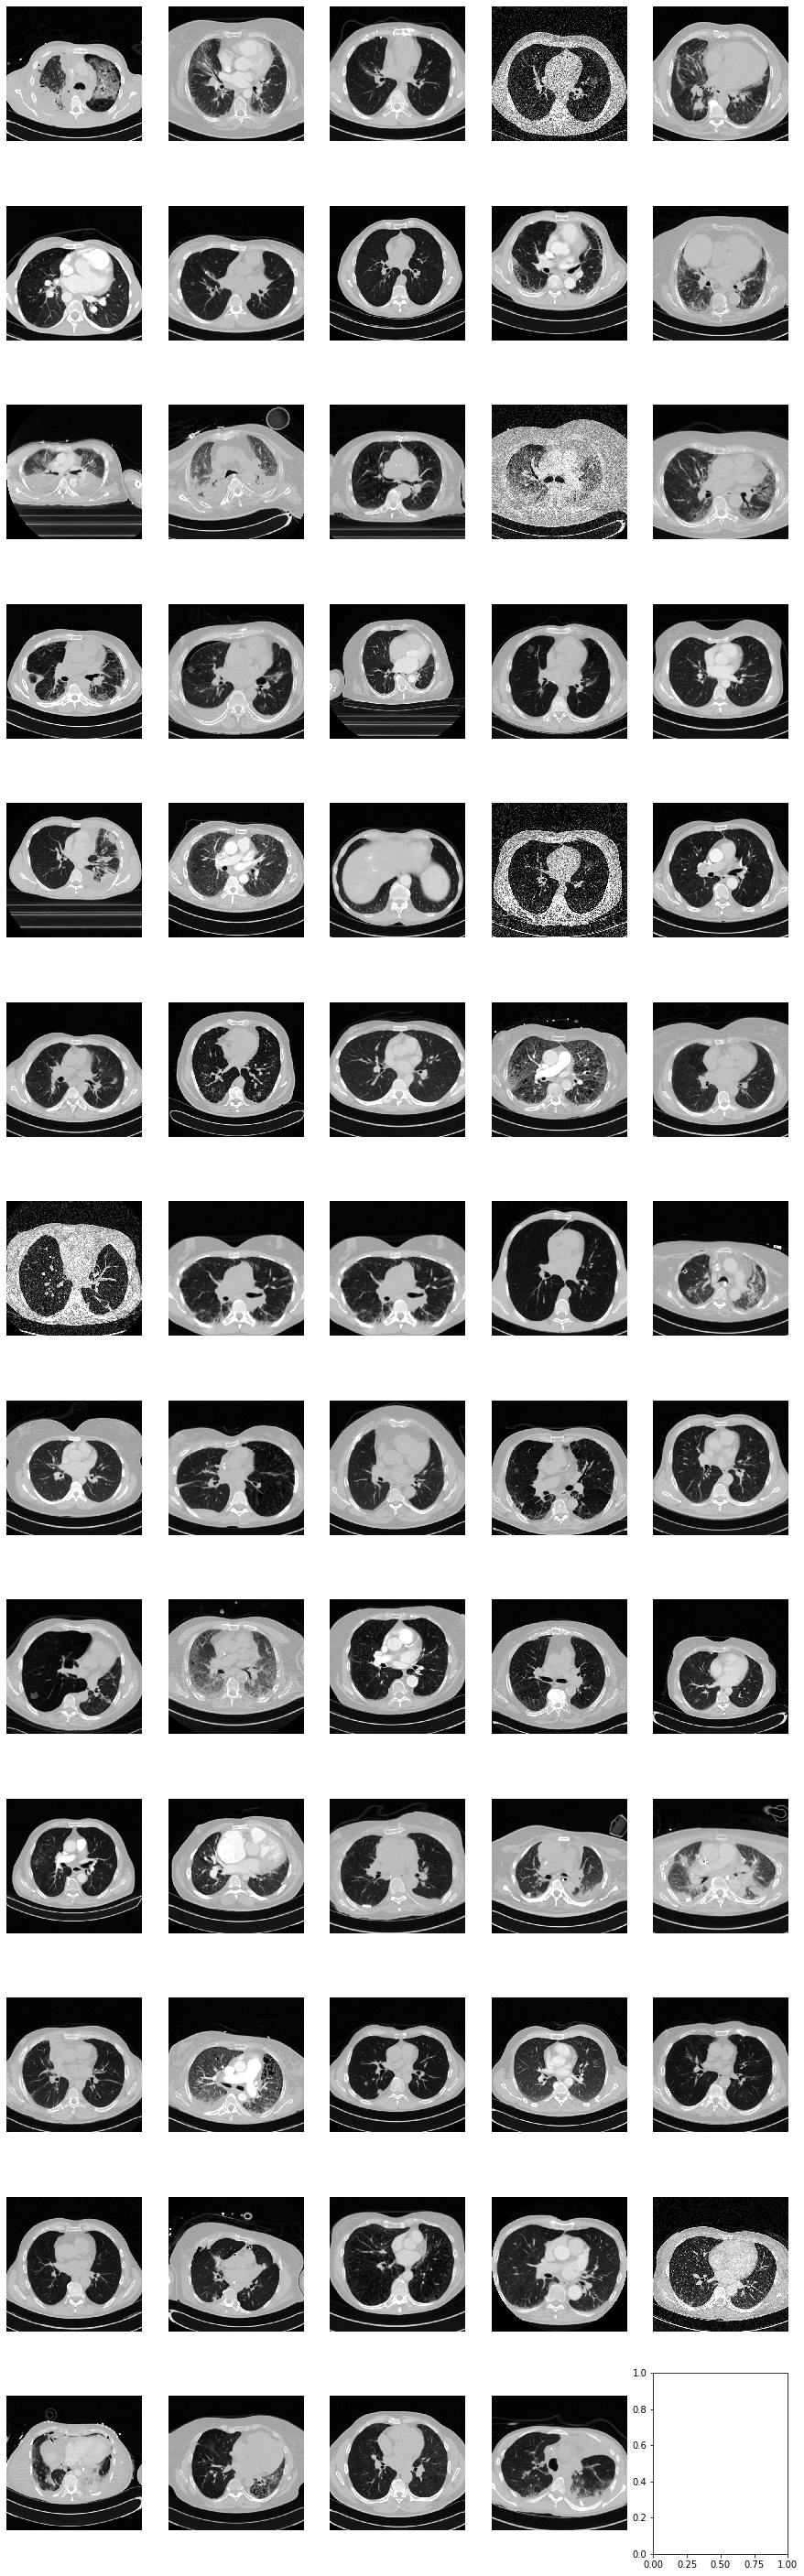

In [6]:
imgs = [x.img.cpu().numpy()[0,0,:,:] for x in model.trainingscache.cachelist]
mut.mimshow(np.asarray(imgs), nslic=64)

In [3]:
test_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_lr_dataset.csv', split='test'), batch_size=8, num_workers=4)
test_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_hr_dataset.csv', split='test'), batch_size=8, num_workers=4)
device = torch.device('cuda')

In [4]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def plot_test_roc(dsname, datasets, device, base_only=False):
    hparams = dict()
    hparams['root_dir'] = '/project/catinous/cat_data/'
    hparams['datasetfile'] = 'catsinom_combined_dataset.csv'
    hparams['batch_size'] = 2
    hparams['training_batch_size'] = 8
    hparams['transition_phase_after'] = 0.7
    hparams['cachemaximum'] = 8
    
    if base_only:
        dsname = dsname + 'base'
    
    model = CatsinomModelGramCache(argparse.Namespace(**hparams))
    model.load_state_dict(torch.load('/project/catinous/trained_models/' + dsname + '.pt'))
    model.to(device)
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(dsname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

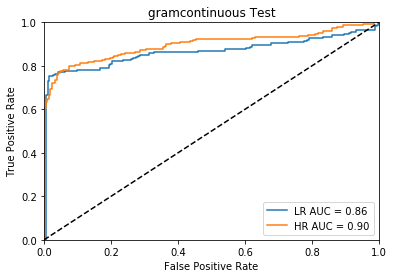

In [34]:
plot_test_roc('gramcontinuous', {'LR': test_lr, 'HR': test_hr}, device)

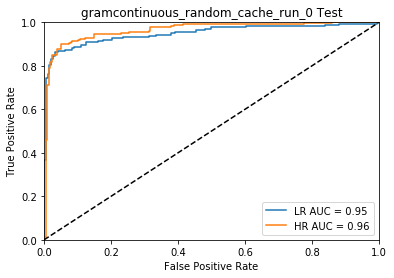

In [10]:
plot_test_roc('gramcontinuous_random_cache_run_0', {'LR': test_lr, 'HR': test_hr}, device)

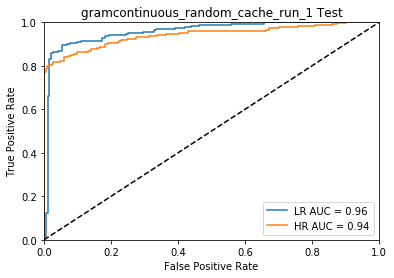

In [9]:
plot_test_roc('gramcontinuous_random_cache_run_1', {'LR': test_lr, 'HR': test_hr}, device)

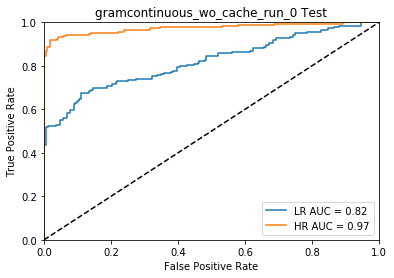

In [5]:
plot_test_roc('gramcontinuous_wo_cache_run_0', {'LR': test_lr, 'HR': test_hr}, device)

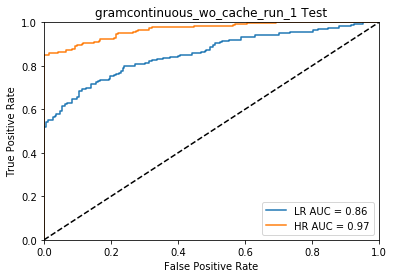

In [6]:
plot_test_roc('gramcontinuous_wo_cache_run_1', {'LR': test_lr, 'HR': test_hr}, device)

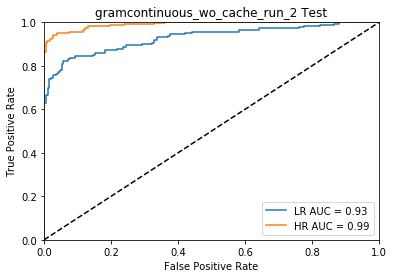

In [7]:
plot_test_roc('gramcontinuous_wo_cache_run_2', {'LR': test_lr, 'HR': test_hr}, device)

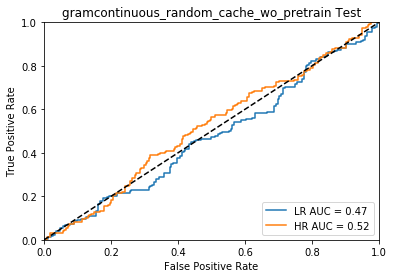

In [4]:
plot_test_roc('gramcontinuous_random_cache_wo_pretrain', {'LR': test_lr, 'HR': test_hr}, device)

In [7]:
out = model(torch.tensor(test_lr_ds[40][0][None, :, :, :]).float())
lr_grammat1 = model.grammatrices.copy()

out = model(torch.tensor(test_lr_ds[-40][0][None, :, :, :]).float())
lr_grammat2 = model.grammatrices.copy()

out = model(torch.tensor(test_hr_ds[40][0][None, :, :, :]).float())
hr_grammat1 = model.grammatrices.copy()

out = model(torch.tensor(test_hr_ds[-40][0][None, :, :, :]).float())
hr_grammat2 = model.grammatrices.copy()

In [10]:
from torch import tensor

In [14]:
test_comb_ds = CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dataset.csv', split='test')

/home/mperkonigg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [24]:
df

,train_loss,epoch,created_at,val_loss_lr,val_acc_lr,val_loss_hr,val_acc_hr,idx
1,NaN,0,2020-02-04 09:23:51.165563,1.615629,0.547368,3.148250,0.495283,0
3,NaN,0,2020-02-04 09:24:20.908379,0.426316,0.881579,0.984000,0.587264,1
5,NaN,0,2020-02-04 09:24:50.943119,0.318587,0.886842,0.798890,0.549528,2
7,NaN,0,2020-02-04 09:25:19.943201,0.321509,0.873684,0.684295,0.566038,3
9,NaN,0,2020-02-04 09:25:49.604091,0.349368,0.900000,0.697287,0.570755,4
...,...,...,...,...,...,...,...,...
113,NaN,0,2020-02-04 10:51:26.212142,0.339582,0.873684,0.171975,0.943396,56
115,NaN,0,2020-02-04 10:51:54.924707,0.407720,0.823684,0.167646,0.943396,57
117,NaN,0,2020-02-04 10:52:24.140318,0.352317,0.871053,0.161661,0.952830,58
119,NaN,0,2020-02-04 10:52:53.222018,0.379903,0.847368,0.165204,0.945755,59


In [19]:
df_cache = pd.read_csv('catinous_log_iterations/gramcontinuous_randomcache/version_0/metrics.csv')

/home/mperkonigg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


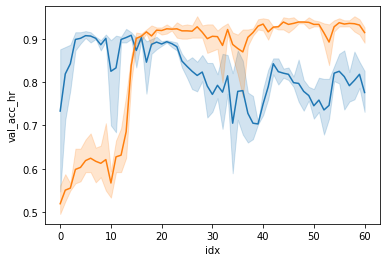

In [26]:
df = None
for i in range(3):
    df_wo_cache = pd.read_csv('catinous_log_iterations/gramcontinuous_wo_cache/version_'+str(i)+'/metrics.csv')
    df_val_wo_cache = df_wo_cache.loc[df_wo_cache['val_loss_lr']==df_wo_cache['val_loss_lr']]
    df_val_wo_cache['idx'] = range(len(df_val_wo_cache))
    if df is None:
        df = df_val_wo_cache
    else:
        df = df.append(df_val_wo_cache)

sns.lineplot(data=df, y='val_acc_lr', x='idx')
sns.lineplot(data=df, y='val_acc_hr', x='idx')

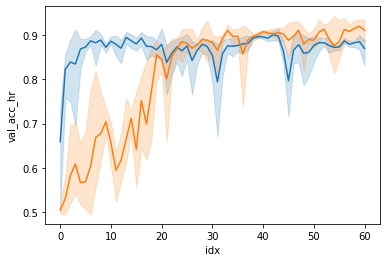

In [31]:
df = None
for i in range(3):
    df_cache = pd.read_csv('catinous_log_iterations/gramcontinuous_random_cache/version_'+str(i)+'/metrics.csv')
    df_cache = df_cache.loc[df_cache['val_loss_lr']==df_cache['val_loss_lr']]
    df_cache['idx'] = range(len(df_cache))
    if df is None:
        df = df_cache
    else:
        df = df.append(df_cache)

sns.lineplot(data=df, y='val_acc_lr', x='idx')
sns.lineplot(data=df, y='val_acc_hr', x='idx')

,train_loss,epoch,created_at,val_loss_lr,val_acc_lr,val_loss_hr,val_acc_hr,idx
1,NaN,0,2020-02-04 09:54:24.121625,0.383624,0.876316,1.598496,0.561321,0
3,NaN,0,2020-02-04 09:54:54.382112,0.432008,0.863158,1.719616,0.554245,1
5,NaN,0,2020-02-04 09:55:23.782062,0.393849,0.860526,1.214621,0.566038,2
7,NaN,0,2020-02-04 09:55:52.796908,0.286518,0.907895,0.857222,0.646226,3
9,NaN,0,2020-02-04 09:56:22.261339,0.281709,0.889474,0.913211,0.646226,4
...,...,...,...,...,...,...,...,...
113,NaN,0,2020-02-04 10:21:32.588508,0.447356,0.828947,0.218110,0.929245,56
115,NaN,0,2020-02-04 10:22:02.258010,0.450400,0.797368,0.211778,0.929245,57
117,NaN,0,2020-02-04 10:22:30.832079,0.586759,0.781579,0.229971,0.917453,58
119,NaN,0,2020-02-04 10:23:00.064716,0.568329,0.786842,0.239541,0.910377,59


In [8]:
for i in range(len(lr_grammat2)):
    print(lr_grammat2[i][0].size(), len(lr_grammat2[i]))

torch.Size([256, 256]) 4
torch.Size([512, 512]) 4
torch.Size([1024, 1024]) 4
torch.Size([2048, 2048]) 4


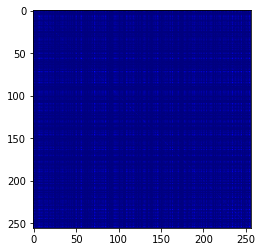

In [11]:
plt.imshow(lr_grammat1[0], cmap='jet', vmax=0.0090)

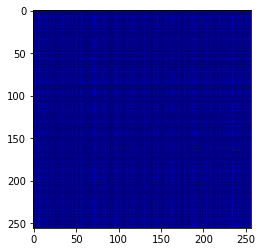

In [12]:
plt.imshow(lr_grammat2[0], cmap='jet', vmax=0.0090)

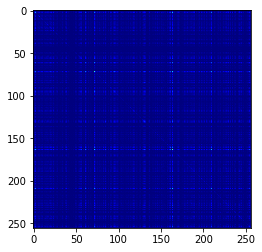

In [13]:
plt.imshow(hr_grammat1[0], cmap='jet', vmax=0.0090)

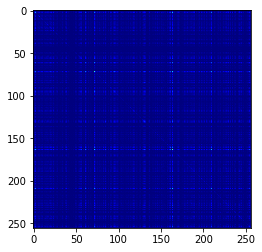

In [14]:
plt.imshow(hr_grammat1[0], cmap='jet', vmax=0.0090)